Logging into the huggingface hub to connect to the repo for the model.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Downloading the UCF101 dataset containing videos of different categories.

In [3]:
from huggingface_hub import hf_hub_download

hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset")

Unpacking the dataset.

In [4]:
import tarfile

with tarfile.open(file_path) as t:
     t.extractall(".")

Creating an array containing paths to a video of each category.

In [5]:
all_video_file_paths = [
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c04.avi',
'UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g14_c01.avi',
'UCF101_subset/test/Archery/v_Archery_g16_c01.avi',
'UCF101_subset/test/BabyCrawling/v_BabyCrawling_g03_c01.avi',
'UCF101_subset/test/BalanceBeam/v_BalanceBeam_g11_c02.avi',
'UCF101_subset/test/BandMarching/v_BandMarching_g05_c02.avi',
'UCF101_subset/test/BaseballPitch/v_BaseballPitch_g11_c02.avi',
'UCF101_subset/test/Basketball/v_Basketball_g02_c02.avi',
'UCF101_subset/test/BasketballDunk/v_BasketballDunk_g12_c01.avi',
'UCF101_subset/test/BenchPress/v_BenchPress_g05_c02.avi'
]

Creating dictionaries to convert id to label and label to id, filling both with the label to each unique class.

In [6]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")


Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


Instantiating our video classification model from a pretrained checkpoint and its associated image processor. The models encoder has pretrained parameters and the classification heas is randomly initialized. The warning is because of the random initializing of the weights.

In [7]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: ['decoder.decoder_layers.0.attention.attention.v_bias', 'decoder.decoder_layers.2.attention.output.dense.weight', 'decoder.decoder_layers.0.attention.attention.value.weight', 'decoder.decoder_layers.3.attention.output.dense.bias', 'decoder.decoder_layers.0.layernorm_before.bias', 'decoder.decoder_layers.2.attention.attention.query.weight', 'decoder.decoder_layers.2.attention.attention.q_bias', 'decoder.decoder_layers.0.attention.output.dense.weight', 'decoder.decoder_layers.3.attention.attention.v_bias', 'decoder.decoder_layers.2.attention.attention.v_bias', 'decoder.decoder_layers.3.attention.attention.key.weight', 'decoder.decoder_layers.0.intermediate.dense.weight', 'decoder.decoder_layers.2.layernorm_after.weight', 'decoder.decoder_layers.3.layernorm_before.bias', 'decoder.decoder_layers.0.intermediate.dense.bias', 'decoder.decoder_layers.2.output.dense.weig

Importing some pytorch libraries.

In [8]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

c:\Users\lukeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


Defining constants for the training dataset transformations.

- mean
- standard deviation
- spatial resolution
- frame number
- sample rate
- fps
- duration of the clip

In [9]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

Applying transformations to the train dataset.

- uniform temporal subsampling
- pixel normalization
- random cropping
- horizontal flipping

In [10]:
import os

dataset_root_path = 'C:/Users/lukeb/OneDrive/Dokumente/Uni/Semester 8/Bachelorarbeit/Transformers/Video Classification/UCF101_subset'

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

Doing the same process for the validation and test datasets.

In [11]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

Printing how many videos are in the datasets.

In [12]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

300 30 75


Visualizing the preprocessed videos.

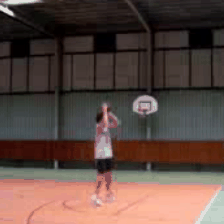

In [13]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

Definining the arguments for the trainer.

In [14]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 2
batch_size = 8

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

Funtion to compute the metrics from the predicitons. The only preprocessing needed is taking the argmax of the predicted logits (log of probability).

In [15]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Batch examples together consisting of 2 keys, pixel values and labels.

In [16]:

import torch

def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Passing the model, trainer arguments, datasets, the image processor as a tokenizer (to make sure it is also uploaded to the repo), the compute metrics function and data collator to the trainer.

In [17]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

c:\Users\lukeb\OneDrive\Dokumente\Uni\Semester 8\Bachelorarbeit\Transformers\Video Classification\videomae-base-finetuned-ucf101-subset is already a clone of https://huggingface.co/Luke537/videomae-base-finetuned-ucf101-subset. Make sure you pull the latest changes with `repo.git_pull()`.


Calling the trainer, optionally continuing at a checkpoint.

In [19]:
train_results = trainer.train(resume_from_checkpoint = True)

c:\Users\lukeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/74 [00:00<?, ?it/s]

{'loss': 2.3182, 'learning_rate': 4.848484848484849e-05, 'epoch': 0.14}
{'loss': 2.1408, 'learning_rate': 4.0909090909090915e-05, 'epoch': 0.27}
{'loss': 2.1028, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.41}


c:\Users\lukeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'eval_loss': 1.797682762145996, 'eval_accuracy': 0.5857142857142857, 'eval_runtime': 280.1979, 'eval_samples_per_second': 0.25, 'eval_steps_per_second': 0.032, 'epoch': 0.51}


Upload to huggingface hub.

In [18]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/329M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.87k [00:00<?, ?B/s]

To https://huggingface.co/Luke537/videomae-base-finetuned-ucf101-subset
   26cf54a..b2c7544  main -> main

To https://huggingface.co/Luke537/videomae-base-finetuned-ucf101-subset
   b2c7544..2a613de  main -> main



'https://huggingface.co/Luke537/videomae-base-finetuned-ucf101-subset/commit/b2c75447552b1ae9061053ff8f4079d920603f42'

Loading a video for inference.

In [1]:
sample_test_video = next(iter(test_dataset))

NameError: name 'test_dataset' is not defined

Instantiating a pipeline for video classification with the model and passing the video.

In [4]:
from transformers import pipeline

video_cls = pipeline(model="sayakpaul/videomae-base-finetuned-ucf101-subset")
video_cls(sample_test_video)

c:\Users\lukeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lukeb\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


[{'score': 0.9272985458374023, 'label': 'BasketballDunk'},
 {'score': 0.01777704805135727, 'label': 'BabyCrawling'},
 {'score': 0.016630113124847412, 'label': 'BalanceBeam'},
 {'score': 0.009560933336615562, 'label': 'BandMarching'},
 {'score': 0.006897935178130865, 'label': 'BaseballPitch'}]